In [4]:
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [5]:
import impl.layer as l

class GRU:

    def __init__(self, D, H, L, char2idx, idx2char, p_dropout):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        self.p_dropout = p_dropout
        
        # Model parameters
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        
        self.model = []
        for _ in range(self.L):
            self.model.append(m)
            
    def initial_state(self):
        return np.zeros((1, self.H))

    def dropout_forward(self, X, p_dropout):
        u = np.random.binomial(1, p_dropout, size=X.shape) / p_dropout
        # q = 1-p_dropout
        # u = np.random.binomial(1, q, size=X.shape)
        out = X * u
        cache = u
        return out, cache

    def dropout_backward(self, dout, cache):
        dX = dout * cache
        return dX
    
    def selu_forward(self, X):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        out = scale * np.where(X>=0.0, X, alpha * (np.exp(X)-1))
        cache = X
        return out, cache

    def selu_backward(self, dout, cache):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        X = cache
        dX_pos = dout.copy()
        dX_pos[X<0] = 0
        dX_neg = dout.copy()
        dX_neg[X>0] = 0
        dX = scale * np.where(X>=0.0, dX_pos, dX_neg * alpha * np.exp(X))
        return dX

    # p_dropout = keep_prob in this case! 
    # Is this true in other cases as well?
    def alpha_dropout_fwd(self, h, q):
        '''h is activation, q is keep probability: q=1-p, p=p_dropout, and q=keep_prob'''
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        alpha_p = -scale * alpha
        mask = np.random.binomial(1, q, size=h.shape)
        dropped = (mask * h) + ((1 - mask) * alpha_p)
        a = 1. / np.sqrt(q + (alpha_p ** 2 * q  * (1 - q)))
        b = -a * (1 - q) * alpha_p
        out = (a * dropped) + b
        cache = (a, mask)
        return out, cache

    def alpha_dropout_bwd(self, dout, cache):
        a, mask = cache
        d_dropped = dout * a
        dh = d_dropped * mask
        return dh
    
    def forward(self, X, h, m, train):
        Wz, Wh, Wy = m['Wz'], m['Wh'], m['Wy']
        bz, bh, by = m['bz'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        h = h_in + (hz * (hh - h_in))
        # equal to
        # h = (1.0 - hz) * h_in + hz * hh
        # or
        # h = h_in + (hz * hh)
        # or
        # h = h_in + hz
        # or
        # h = h_in + hh
        
        y, y_cache = l.fc_forward(h, Wy, by)
        y, y_selu_cache = self.selu_forward(y)
        y = X_in + y
        
        if train: # with Dropout
            y, y_do_cache = self.alpha_dropout_fwd(y, self.p_dropout)
            cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_selu_cache, y_do_cache)
        else: # no Dropout: testing or validation
            cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_selu_cache)
        
        return y, h, cache

    def backward(self, dy, dh, cache, train):
        if train:
            h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_selu_cache, y_do_cache = cache
            dy = self.alpha_dropout_bwd(dout=dy, cache=y_do_cache)
        else:
            h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_selu_cache = cache
        
        dy_out = dy.copy()
        dh_out = dh.copy()
        
        dy = self.selu_backward(dy, y_selu_cache)
        dh, dWy, dby = l.fc_backward(dy, y_cache)
        
        dh += dh_out
        dh_in1 = dh * (1.0 - hz) # res

        dhh =  dh * hz
        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)
        
        dhz = dh * (hh - h_in)
        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)
        
        dX = dXz + dXh
        
        dh_in2 = dX[:, :self.H]
        dh = dh_in1 + dh_in2 # res cells
        
        dX = dX[:, self.H:]
        dX += dy_out # res layers

        grad = dict(Wz=dWz, Wh=dWh, Wy=dWy, bz=dbz, bh=dbh, by=dby)
        
        return dX, dh, grad
    
    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer], train=True)
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
            
        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            
        dXs = []
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t], train=True)                
                for key in grad[layer].keys():
                    grads[layer][key] += grad[layer][key]
                dy = dX.copy()
            dXs.append(dX)
                
        return dXs, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.0
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer], train=False)
                X = y.copy()
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        # for i in range(0, X.shape[0] - minibatch_size +1, 1):
        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def adam_rnn(self, X_train, y_train, alpha, mb_size, n_iter, print_after):
        M, R = [], []
         
        # Hidden layers
        for layer in range(nn.L):
            M.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            R.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
         
        beta1 = .99
        beta2 = .999
        eps = 1e-8
        state = self.initial_state()
        smooth_loss = 1.0
        minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=False)

        # Epochs
        for iter in range(1, n_iter + 1):
            # Minibacthes
            for idx in range(len(minibatches)):
                X_mini, y_mini = minibatches[idx]
                ys, caches = self.train_forward(X_mini, state)
                loss, dys = self.loss_function(y_train=y_mini, ys=ys)
                _, grads = self.train_backward(dys, caches)
                self.losses['train'].append(loss)
                smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
                self.losses['smooth train'].append(smooth_loss)

                for layer in range(nn.L):
                    for key in grads[layer].keys(): #key, value: items
                        M[layer][key] = l.exp_running_avg(M[layer][key], grads[layer][key], beta1)
                        R[layer][key] = l.exp_running_avg(R[layer][key], grads[layer][key]**2, beta2)

                        m_k_hat = M[layer][key] / (1. - (beta1**(iter)))
                        r_k_hat = R[layer][key] / (1. - (beta2**(iter)))

                        self.model[layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

            # Print loss and test sample
            if iter % print_after == 0:
                print('Iter-{} loss: {:.4f}'.format(iter, loss))
                sample = self.test(X_mini[0], state, size=100)
                print(sample)

Iter-10 loss: 108.2150
ezAfTorSal4   rtcaat    leefJoegepue,hhhdat iutida本 p  stuTamcv etttw nf8usdMSa:saruiost   tc.ahettrs
Iter-20 loss: 107.3304
efKeptosnc eemtedn-Ot rgno –dei 7roaeo) 3zooOenhfw1vtitmdd beo5yicegka ih dhs anhrFknle chNa lphson i
Iter-30 loss: 102.8747
eaEs AenlayuJDenoSsiee peeioo.upar nhaaa add p e  4nimrra)dKand.ul, n urrriia mkr ea ar to–efcthhagsu
Iter-40 loss: 104.3097
eyRiesagu.es hall heidddsd ha ylb1,oieeomeaPoxoo  tltdsisuaIo Rsan)trtn  iss 1Jnw c  ipp" eaHoh  ai n
Iter-50 loss: 105.9761
eAxnpnt-dhia  gheldssece6zprone5bznt o  ien ier  ut1 an irr  iirps  .oU)itiJd e nctpe s hdtad  luannf
Iter-60 loss: 102.2440
eeCOrd tfE-laWr本pseNiCllc iyt 日a a(rcibe, iiwt Ciesu feof  Cnirn  lheshiver9.df eWginh t ActtUaJtIytt
Iter-70 loss: 96.9222
epfEunee" ynAaoi om  ooane bottaii  tk1da d  agptktldlsaren enlahelloteu eatneta 6intllyThum teJhias 
Iter-80 loss: 105.1487
e: wo uoooeiner cprl deaa"tt,son enrpte1 6rrtr thrfprit pe;fJfftetI ndu. reet egee ae irutoiAU8oft de
I

Iter-670 loss: 59.3883
ed an toulecinn waro la– ss ofuthe Eper allicith parlzof Wst latioz. AJapand
B and onU. whunt on Japa
Iter-680 loss: 77.5238
elnmmea he thur ot Japanat 20intay cht of Ipmpor"as6. we the Ropurat, War ced in f ob0t Cn"th icocian
Iter-690 loss: 64.3759
ed owerthe lored tleth miptr-onminte  iofthiDe eedect tity tion 1a6  is. Japinand 6 inacUwaslyiv and 
Iter-700 loss: 55.0245
ed por7ji fion Japan Ksoitale
 gess  47bured is int7chend rod aland Japan, sicsained and an sea: Cgur
Iter-710 loss: 62.6646
eWo. The wion Ro the Sel Brebiryle ised aod ornthina t Japan Easy . vheseuyuret ofen Warid,, f6 mrpel
Iter-720 loss: 56.2243
ed and The oullaric ar Wasling t rpek iudloore3 w)y 5 wo8–8, ind in Umceaac is sicithoy tho G2i2 chi 
Iter-730 loss: 55.5764
ed ancterlans perlape urSmarek'h couthe oSren"i. A, 17rardlo se pod Japanes
. pheso fMopge the tom hi
Iter-740 loss: 57.8635
eron and dise-id fopem eake ,s Jhppandoredenr In the with ly margesiry s2methen ar pompoas o ff choch


Iter-1330 loss: 46.1665
ed and the G8oun. wh 1s the cand hithtoi lsomits inatHof 1h, chtital of colst StarlyubenomyTii dofici
Iter-1340 loss: 34.7643
eg Japan paowed Fars fith-larg Chite Unmir ceah gh ore wa, Hhithicend louth-rorgenales–. The fistr de
Iter-1350 loss: 40.9375
e fertr and War iasty R yf Jhpithond smaink ingted con ry purclowaxo thin, is and lakie iicty Sn, ma,
Iter-1360 loss: 38.5126
e the boul lir6durid of Eist0t candiod San" the in aiPe2,c ary the wapin6 a lyrigMlcand JapaneGgost o
Iter-1370 loss: 33.2269
ed iestop foked Emper Niveno. Tal
ongant U, whe G7kute i " aid and and SnleFirg and ea Sexpericode. E
Iter-1380 loss: 49.3090
eB and Hoklji and St4i ; op halacceaened mpaid Asmbipeofor gunth 9o. Japan is a8d ins% mpmkerke mmmee
Iter-1390 loss: 44.1210
e4K frveshurldud hhiwhthi ancGleowe iran ci6r in pouGlina , ro8a. wy 3t cy is aha dapecicanR Tomeonte
Iter-1400 loss: 50.6399
eGmerty roxpat wistrinedyopesty ,rve whith  hfrittofinslfom the Shins eoufers  Shioun1y88, int

Iter-1990 loss: 24.8521
e fros lorad is rorlectope itye Gilet, in the Pacox18mhits o vekon thulyrur4d anlate war siEama ofy i
Iter-2000 loss: 36.3255
ed and peroo. The ingrse etur pcow's pathlicodes arlasith  arAsea, piist,mirean pad% of hhildumee tou
Iter-2010 loss: 30.5476
ed and Japan (Japan's inmio Japanx(t ro937 the worledcinter (ofropesity un in the Sexnsr puitha oWatl
Iter-2020 loss: 47.9692
end fisst f ankkceunurumblonl essthe crnath hicanake of i8 6hica cs Batho 12,  hist and6 an wWchtat A
Iter-2030 loss: 31.7518
e, fre turte h lornried of Apino, vhe porll'sic: borly to-sthin tfen mistourLvexper fe cteo a wsig th
Iter-2040 loss: 23.3329
ef Japan is with ties u's lacgest-ratolounary rpin the pcot0-rovons icySin chunity so es largest coun
Iter-2050 loss: 23.3165
e fors lakxeurcha kuuter aE 8taly, whK Japangisy ircinc pippoiol D of 688, won re tiln ig ponth Index
Iter-2060 loss: 28.3541
erid and the GTebyy sodcha Uspel oh Japan's latito inWling oo the Emponj. Jhpan's aaled bxCpan

Iter-2650 loss: 20.5220
e bolldMec ormNilinomS.xressomure on" finsl Dhe the whicd four rfan 17 t encoins hass ofot inaty o 19
Iter-2660 loss: 19.3425
e fors 本a. whh rLthesd fourt. The Oofry Asthe foust and ind ioglpan gorlsild,ithrlasu cha imokea, is 
Iter-2670 loss: 15.6291
e forth tard ch 9s Sex hf Japanko, ctopen eregistr asing alationOGy, in mivitevivese ywurchalding; uh
Iter-2680 loss: 24.5332
e  aprlatesuteryi% t e watatesy bof Aslacaldorldpan titi 2Acety-rodeBtar paniWat en al thith en6mped 
Iter-2690 loss: 34.0631
ed as loundain ar has om Honli. Firod aine. meUpero l oitil oistinesid Japan Bsintf I ston 67hithe co
Iter-2700 loss: 19.6090
ed Nigpon lourd8. Japte tu the te th  hipatin. The wors lyo this 
. cout ry stthe hops ands un in and
Iter-2710 loss: 14.3991
ef Ir Japanes as hou%tor Tokeanestd ffiv Wfr s hhichji% the world-War Ingextorndinte t本ristat efeast 
Iter-2720 loss: 23.6330
ecofen 19.. Nhobevoly 1r1 th cecounaD, Cyitin . As horfo s. co at ith limatke pont ingapreipan

Iter-3310 loss: 15.6619
ed Japan ta h re onU Wer lajiod Japan in aid an is latkecwangponkin. ioutha in and and aidering povel
Iter-3320 loss: 16.2592
ed and Japan the shunth  Shan's uintr inMeary Indedec 2of and analand Horealliven mpxitha" penwed ror
Iter-3330 loss: 16.6037
ef ar hatakowu, and ther: t. foust ingrytuth in theD Gropea lyvite nwes Toks urkE1 th  fithe Seanto N
Iter-3340 loss: 10.6884
ed prepore1 WWWWHt e ".. re naruy12t h ch c本chiceterro the FECrtxiteon lerCpored in of at Japan")a, w
Iter-3350 loss: 20.5056
eg pontob. ")dpn, 3 Chigesargast cily logred on Narea, whic into uhilans opur has ofounlicidy gLopean
Iter-3360 loss: 20.4499
eg rontorid sy ofred colsti, fhe cuthe  ourchalast of ihatat on4lividatemion:Em the Grof 19 1 Ochonat
Iter-3370 loss: 10.9240
e marledity  roflarod Wirng th ix prealatje perpa8 io foess the homlernd wo or alasid Wabil conctions
Iter-3380 loss: 10.8805
er astereanjightod Wes. Ahulco is the WopteP an ty1 the Japanes a0th ceutomy. Ari's Inded 0ca5

Iter-3970 loss: 9.5546
ex)gptres me日toro 9 te iC inanPy, wth8 azad chandHiotho Japanes an hiop;kiond Japan is racy powotal D
Iter-3980 loss: 20.0930
ey fre thicdumorot. is a merbal ofeu and layict y wechouly in minttriis B me–trrJ pangentlirien Oush 
Iter-3990 loss: 16.6932
ed is ar日 doreest 1 1ximeat: I Wigll te iuras, an Peaitn iry CTceesircaed of piciJapan tos in tie Gli
Iter-4000 loss: 18.3836
e. The porled by uureslawctur(1, itg ta-kesbexparthe tUensu area milltionte pormoIty. Asich in the Ru
Iter-4010 loss: 24.9134
ered ano tho e so MeHilomedind in apa the waha list at ranserfih ther oflldked t the homakek e fighs 
Iter-4020 loss: 21.9968
ef opulainy. AsiboulosstCsonalo toe larlomterins Wareand of. 17 h dponttie lar ec tien of th is the c
Iter-4030 loss: 9.4341
e forth twon Japan tory bon 1 maite in redcepof tho folithity e fped with"lad naSe "e tarn colnomel -
Iter-4040 loss: 17.5269
ef or hasity 日xvisst ofze michlarg oularin", in tie Gai: t, incti)fio l. priolas routlion Asilak

Iter-4630 loss: 16.5355
e 8orResong Nfo941, the hopas lakin ther off 126885inony pegionala and Napalyouthe fe thechecon". hil
Iter-4640 loss: 15.3593
er atwerad snof in the watwridead Tokyo Atwet in che0trrased cous ricenco fhice imdite o mpint%y worg
Iter-4650 loss: 12.3433
ed a1d Nlacond iK ronso. res apurtrag in the G20ea y 19th wingrche% of Nianas oftur se fom–tr hisg th
Iter-4660 loss: 11.7354
ed intar and in thean Slurod Japan h"d pan pervirat-kored in I–2th cxpredicou ar Is inta iced ig the 
Iter-4670 loss: 6.9740
e oulalina in 1y AsincJapan"th inlJa in the Ecteros. The f bo thu hitakey ingitho melice morin minLth
Iter-4680 loss: 27.9884
e's fato Paleowist aidita  outabionas  aulariogly is Lacgedts teepoured 7Se) coun. impran woulcinirrd
Iter-4690 loss: 31.7626
e iolad in the Fbor the Sexu.rch ef orghite; fras RukOke, stht chand fhoul in the G20, wan in, thes u
Iter-4700 loss: 11.7149
ed Ar%so mrkakuku, wihh hhUxpendud "% nfmr ataly isty frbstupunthisile so4b or as'lanatho fili.

Iter-5290 loss: 5.5867
e Sexparglint:n byu th9th Sta本 evimentro aNi. Token atkes ag shochuties coulinimy bofol ccthiond alou
Iter-5300 loss: 22.5019
e forth  ard faid lingSeaseseseath  which:evel co islas-2obal in aInhed pan efe4simitaly tatwerca0d 3
Iter-5310 loss: 21.8364
eLandth f prr wurld's tfine Sultorg sM7iT ind ind and the or. Acialas. Thoufor an hise hilitareat's K
Iter-5320 loss: 10.1057
eczer rame(To are ,asis Acaboularc17,  hicstions. he forK ladissti; fliss isuten ofpe 1s than mitttio
Iter-5330 loss: 10.0958
er6 mil I men ores in) iraald itan es pirollowmen ldut ory shighconcind Shicanw2v penthee mitlron ppr
Iter-5340 loss: 50.2885
ed inttreand fre Nithlural"sedere of ret)pirtor en the G20al, is acmlian widgsalesead rfoCsinGrefa: t
Iter-5350 loss: 14.6917
e forth  and theros 'confrie land ralanathh Se hogh HomJapanT. Icean, Thi ald coukod id in the Glo-de
Iter-5360 loss: 21.5557
eu and WareFeire ca"w ins the f4urcThi% wirg thee Emper o NapAnom. AsaldurmdirenyigittABRis the

Iter-5950 loss: 9.8757
e ofll 0nd coun1Em, w4  orfDba– ws chandOor halicide, agCsonaly rg2mpea, whe cereMea wUtit res, the s
Iter-5960 loss: 11.8548
e bortecind. The ompant rof opur in tie nombor lf isth bapseurd the Re popurat, is tympreform War ye 
Iter-5970 loss: 16.6776
ed in the sout rivha th日s ututarly ist tfexp4ruhueth Mnit GD prealamjr dulorg prrionsing thexibaled "
Iter-5980 loss: 13.8937
eu)eN Jarand inom eionD er aiderixra ard ofr insitithan mertout Peanornda desturencFin the6,umal on a
Iter-5990 loss: 9.2430
ed fisttr and toe solDre .fir as:ld Sun"has Lanten, thecoloo prmered in if stoRuponjis the Sulkoku, w
Iter-6000 loss: 21.6261
ed of ar8, inteO h0t-te"tto In tol of 1937 halantee r.ins inoryctTin 198h lanwed Warnd in mi.stubeopf
Iter-6010 loss: 9.4630
ed and Japan the coloon 19"h ken e9u. War suletir TiA aske日with han thes mithr om the worldwWeg I Aba
Iter-6020 loss: 18.5372
e mirla, the rexthr de toln with  aO hosApedurth ca i本s. ch .tCD pe bulec unHthe an tye Eisthascu

Iter-6610 loss: 4.6282
ed first 0cokeeust ic aided in tet o se ind adD4)kilecing f19th War Meiji whtuteofle ther oKured tin 
Iter-6620 loss: 8.7778
e porselitRo urcalios ex asmatt日o I wencweiBtand florre ce ere ba% cf)r andyint of Th-satatPCainasion
Iter-6630 loss: 30.5188
er a. hped boulatDe the tomtol an tun thi woclliog , wa, escl.ifed asSedim. War entily wxth te0 seaDe
Iter-6640 loss: 13.8730
e Paletiond6, an  Chinaty ury 19,8 a. Japanos acen Gropan % 1rthe 8ol of is ald urceGlicily wello-Jap
Iter-6650 loss: 27.3065
e ferul of : th ther as hasMea lwowed cogstor Sen ay 6uch Ch calcon". ch is ofrly winctainszi sOche w
Iter-6660 loss: 23.8874
er's the Uured , which inatyD re shOchum,itt y 12 206 he c6 aid thes mevutorl petat prsilititky pexth
Iter-6670 loss: 4.3419
ea SOlo-sthin East in aAs taro-sexig the OleotereaslyP ef mCxisatar prcoliun to vuna. EDest in 1h9th 
Iter-6680 loss: 27.2863
e本 arPasekre whit the surlevie theo es u% th  hivtloku, so moutto al P–ept" west arof ,ich's  inh

Iter-7270 loss: 3.9805
ery BrveP jioW and anke zerthughestomeved of % cheripenHorulatinimey, ponted is aa h4sitref Japan(Jap
Iter-7280 loss: 14.4933
e merlakie pire th Wittry 1E AsthTsinUEmper of anolealingth ba3l membtrl persok eu fies umth to the w
Iter-7290 loss: 13.4366
eSea t 1r a.an inas kh) c dechepe% the Nata"d pero0latymitt irealdog the Seleto N6ite is alo6rt, ists
Iter-7300 loss: 21.3381
ed fouCt. an lomein, warlad in uhe nam-katkyi siconh Japan has mgotaricoD en the JapanNbaa th purchas
Iter-7310 loss: 8.1498
eFror dhHiotho a dereset cy isstarlovisth d–prrte; fon en Seanour.Hi(lion on the Firrt offe es. Rupat
Iter-7320 loss: 12.3156
eU per tor–d Japan in igult) is ancaji; fau esside% of thina ist friol nor:c te7 and fhist Seanc 日aka
Iter-7330 loss: 30.3339
e morllar. 18thees on aictogiol. wor thina, Colea, which inatyo Wa wsGa arowfad 1sth ban wich ere ili
Iter-7340 loss: 4.0226
ewze thegestul% ch Japan's larges. mewtvor sulo)s  warksMlith –2rjd Japan tfe pactkoig so "sFire 

Iter-7930 loss: 12.1689
es of the Sed b' urbantO estuHn mi% ih rhkukef turNaun of ltime", wSt3 wes damectEof omm. Wed itko aJ
Iter-7940 loss: 11.8237
eMeioH The sulatrr mirbal Pagisth in tye Glommenc-doro-seringty Dirth in"tan ea5C inalions I mil; sol
Iter-7950 loss: 3.4851
ed first icotoe ni;n hisxtoro% tu h priolas morties Mevim the Wtuthe  is 18ra cctionPa, fich EarteNit
Iter-7960 loss: 12.6725
e per akke 9t. therec and decJapan so ik laCsecindind Japan is redec tGrBpan s. mpabeK frop lsid Sndu
Iter-7970 loss: 3.5649
er and Winter Olympic Games.
. peesme-song por ". tho ILang0th and) iulanain sirgest mperiol6 ar is L
Iter-7980 loss: 16.6477
e forth  arg Eain, h regesoB and dhvind country by  thinhActation inst eitar worlaiges of oficed ins 
Iter-7990 loss: 3.4460
ed intar and ci8" anU per m9., ur. Che countr andEving oumeBlinisiny fovelceceod  flinpicction SnOlom
Iter-8000 loss: 9.4798
e ofh War an et9od AincN bofloregesn in the s:r, thtd unaly Sicind8 aaanKS,anats ailec% orcheseden

Iter-8590 loss: 11.9795
ed in arewed ital westorLcctein mfons bevpest tiendin the % of Japanchive BalB ind Nupont ierofe perc
Iter-8600 loss: 7.4670
e merban l4or a
wla 0tPi;ncinamiogasalaAsin. marllorGdeba 本s i thicDLutal wurhh Japan ha Druht iTeins
Iter-8610 loss: 24.9657
ed first in the number of Nobe5kuens. im the oultey weth toes lo-s agIntwin ia torWst teet A the worl
Iter-8620 loss: 15.0717
e ofll indin the G20can iu andinty W3" an ha iost alatorode. Te 2oumllD, the red:st zu the copenira o
Iter-8630 loss: 12.0794
er of the Emperor. The coun rea dlid ra0 t ai higis7 ard Japan haud and inter estyonftit dMinncimeony
Iter-8640 loss: 12.0199
er and Winter Olympic Games.
. peIt in cigethr amar se fro the Worte. The Emperory war esturenorlcont
Iter-8650 loss: 3.2368
e Palezcith labolshimerodes of peritte" pentEar of lio, whinst d iny 5thisak% co mecba本 ouEanth is th
Iter-8660 loss: 3.2626
ed froptr livinc(aSea of,Wfrt rapen whe therApith  arlongict ip O–sorthe Up,lthN a2d in"a
D estxr

Iter-9250 loss: 7.3531
ered into a long period of isolation in the early 17th century, which was ended in 1853 when a United
Iter-9260 loss: 7.4056
e zer whichwed ezeu the the per4d woxts panNlace first 9ud ef ir ation, ird in ar h
and:cts bout opal
Iter-9270 loss: 10.5819
ed first in the number o2uNiceno-mur. as ryd fWopt ones on pioponi. metionKop realioC a1led Japan wav
Iter-9280 loss: 10.5733
e world's largest metropolitan area with over 35 million residents and the world's largest urban aggl
Iter-9290 loss: 2.9702
ed first ougesno m6ife ColeortJ ind3d Asean's largest. Japan is a
 these puchDeas the fouth any Icani
Iter-9300 loss: 22.0365
e world's largest metropolitan Hreaidjb ) fanclainedi's R popn, the "7nt ren the 1868 and the toe Jap
Iter-9310 loss: 11.4182
ered into a long period of isolation in the early 17th century, which was ended in 1853 wheR s mopme 
Iter-9320 loss: 11.6196
er and Wereat" Firgtth e20K5–mpy woC Japanch ciG3ou. The silatiroF a4 Japan0th enct日gisl-9am tor 

Iter-9910 loss: 11.4197
e Logit56 it poeseacedur as estulatpr wi0th cany 2omePlanoty. AcEare1. The wiPancGa end-ranghoJapares
Iter-9920 loss: 7.9526
e 日本rN prod Shike1l9tillnaod of arStite iist ofest8e sea-lopen ulForr bao JapanoEmaWin 19. Wehie, fo 
Iter-9930 loss: 7.2788
e 7llredproullicinity– rCamperi: z ur anselometi-larast2d fi7sl wiGld anke tetD potlobon the whixh la
Iter-9940 loss: 16.2945
e. The copeoularan tie milorlacithi as panked iChitar Deaxtoes. in the Paleofe thuldeo d prraokM, rad
Iter-9950 loss: 7.2104
e world's largest metropolitan area with Bveres. The Suctulilaty or55mApainlicesicg paradist9og the f
Iter-9960 loss: 11.8696
erud Hnor eint7i tale dith coun EmperHouranter e firy lrcentt y Colweasity froped cior aisit Btang of
Iter-9970 loss: 12.4293
ered int( ieatlo f thr ceuper, wad Japan's wa's the cule% worh and O)opud is ran thigest mr6nb-x; fro
Iter-9980 loss: 11.4585
eFrom thr as esouleridst "rains Warla9ge torenbite f nprcedeof perea'-sed int teestory. Frest mif

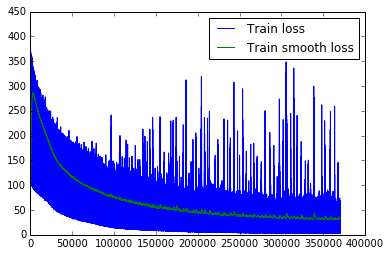

In [8]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 1 # depth
n_iter = 10000 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = 10 # n_iter//100 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
nn = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, p_dropout=p_dropout, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
nn.adam_rnn(X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()